training of a qcGAN with a logistic function for the same epochs of gamma_logistic

In [15]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_logistic as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads
from matplotlib.offsetbox import AnchoredText
import pandas as pd

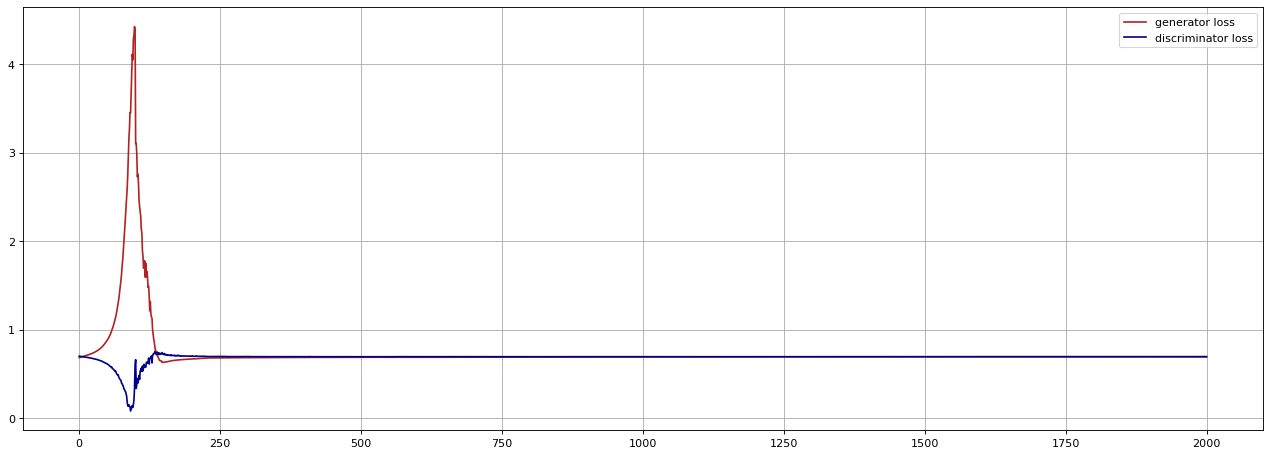

In [18]:
n_layers=328
d_loss = np.loadtxt(f"data/dloss_1Dgamma_1_3_2_10000_{n_layers}_0.1", delimiter=' ')
g_loss= np.loadtxt(f"data/gloss_1Dgamma_1_3_2_10000_{n_layers}_0.1", delimiter=' ')
pyplot.figure(figsize=(20, 7), dpi=80)
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss',color="firebrick")
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss',color="darkblue")
pyplot.legend()
pyplot.grid()
pyplot.show()

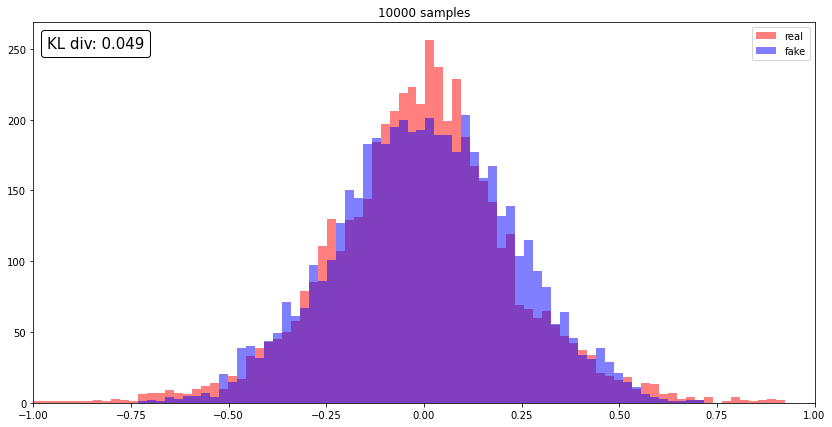

In [22]:
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham

def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems


    
# number of qubits generator
nqubits = 1
# create hamiltonians
hamiltonian1 = hamiltonian1()

latent_dim=3
samples=5000
nqubits=1
layers=2
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))  

distributions=[]
params = np.loadtxt(f"data/PARAMS_1Dgamma_1_3_2_10000_{n_layers}_0.1", delimiter=' ', unpack='true')
params = tf.Variable(params)
#print(params)
x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)
#x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
x_real=qc.generate_training_real_samples(samples)

distributions.append(x_real)
distributions.append(x_fake)

nbins=100
pyplot.figure(figsize=(14, 7))
bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)

ax=pyplot.gca()
at = AnchoredText(
f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
    
pyplot.xlim(-1,1)
pyplot.legend()
pyplot.title("10000 samples")
pyplot.show()

In [23]:
from IPython.display import display
from scipy import stats

moments = pd.DataFrame(
    {
        "distribution":["real","fake 100000" ],
        "mean":[np.mean(i) for i in distributions],
        "2 moment ":[stats.moment(i,moment=2)[0] for i in distributions],
        "3 moment":[stats.moment(i,moment=3)[0] for i in distributions],
        "4 moment ":[stats.moment(i,moment=4)[0] for i in distributions]
    }
)
display(moments)

,distribution,mean,2 moment,3 moment,4 moment
0,real,-0.007587,0.056120,0.000196,0.013920
1,fake 100000,0.002752,0.050065,-0.000340,0.007045


KL DIVERGENCE MEAN: 0.11239260744489914


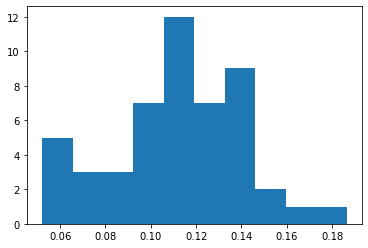

In [21]:
samples=200
kl_mean= []
nbins=20

x_real=qc.generate_training_real_samples(samples)


kl=[]
for i in range (50):
    
    x_fake,_ = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)
    
    bins_fake=np.histogram(x_fake, bins=nbins)
    bins_real=np.histogram(x_real,bins=bins_fake[1])
    

    kl.append(kl_divergence(bins_real[0],bins_fake[0],0.1))
    
              
kl_mean = sum(kl)/len(kl) # mean of KL 

pyplot.hist(kl)

print ("KL DIVERGENCE MEAN:",kl_mean)

In [8]:
np.savetxt('fake_data.dat',x_fake)